# Inverting the vertical component of a single survey line for a thin plate

<!-- Please leave the cell below as it is -->

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/airborne_em/airborne_em_single_line_transmitters_vertical_only.ipynb)

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi
# !pip install git+https://github.com/JuergHauser/PyP223.git

In [2]:
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/examples/airborne_em

In [3]:
import numpy
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cofi

from forward_lib import (
    problem_setup, 
    system_spec, 
    survey_setup, 
    true_model, 
    ForwardWrapper, 
    plot_transient, 
    plot_predicted_profile, 
    plot_observed_profile,
    plot_plate_faces, 
    plot_plate_faces_single
)

numpy.random.seed(42)

## Background

This example inverts a single survey line of VTEM max data using the vertical component for a thin plate target. The dip azimuth of the plate is in the direction of the survey line and we only seek to recover the plate dip, the plate width and the location of the plate along the survey line. The forward problem and model setup is described [here](./thin_plate_inversion.ipynb) and an example using the inline and vertical component is given [here](./single_survey_line.ipynb).

## Problem definition

In [4]:
tx_min = 115
tx_max = 281
tx_interval = 15
n_transmitters = (tx_max - tx_min - 1) // tx_interval + 1
tx = numpy.arange(tx_min, tx_max, tx_interval)

transmitters_setup = {
    "tx": tx,                                                   # transmitter easting/x-position
    "ty": numpy.array([100]*n_transmitters),                    # transmitter northing/y-position
    "tz": numpy.array([50]*n_transmitters),                     # transmitter height/z-position
    "tazi": numpy.deg2rad(numpy.array([90]*n_transmitters)),    # transmitter azimuth
    "tincl": numpy.deg2rad(numpy.array([6]*n_transmitters)),    # transmitter inclination
    "rx": tx,                                                   # receiver easting/x-position
    "ry": numpy.array([100]*n_transmitters),                    # receiver northing/y-position
    "rz": numpy.array([50]*n_transmitters),                     # receiver height/z-position
    "trdx": numpy.array([0]*n_transmitters),                    # transmitter receiver separation inline
    "trdy": numpy.array([0]*n_transmitters),                    # transmitter receiver separation crossline
    "trdz": numpy.array([0]*n_transmitters),                    # transmitter receiver separation vertical
}

In [5]:
forward = ForwardWrapper(true_model, problem_setup, system_spec, survey_setup,  
                         ["pdip", "peast", "ptop", "pwdth2"], data_returned=["vertical"])

['pdip', 'peast', 'ptop', 'pwdth2']


In [6]:
# check the order of parameters in a model vector
forward.params_to_invert

['pdip', 'peast', 'ptop', 'pwdth2']

In [7]:
true_param_value = numpy.array([60, 175, 30, 90])

### True model

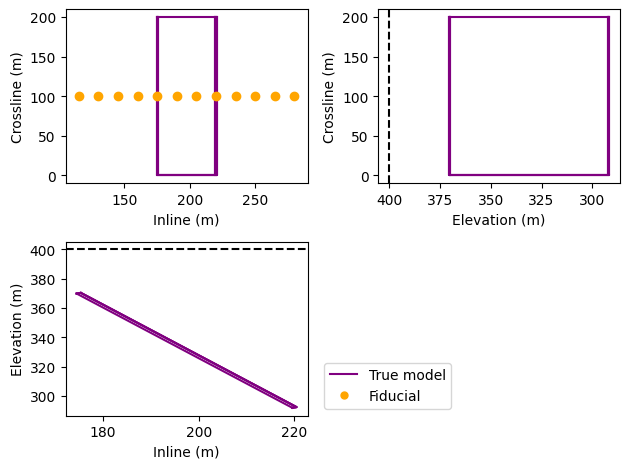

In [8]:
_, axes = plt.subplots(2, 2)
axes[1,1].axis("off")
plot_plate_faces(
    "plate_true", forward, true_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="purple", label="True model"
)
plt.tight_layout()
point = Line2D([0], [0], label='Fiducial', marker='o', markersize=5, 
         markeredgecolor='orange', markerfacecolor='orange', linestyle='')

handles, labels = axes[1,0].get_legend_handles_labels()
handles.extend([point])

axes[1,0].legend(handles=handles,bbox_to_anchor=(1.04, 0), loc="lower left")



### Generate synthetic data

In [9]:
# The data 
absolute_noise= 0.05

# create data and ad a realisation of the noise
data_pred_true = forward(true_param_value)
data_obs = data_pred_true + numpy.random.randn(len(data_pred_true))*absolute_noise

# define data covariance matrix
sigma=absolute_noise
Cdinv=numpy.identity(len(data_obs))*(1.0/(sigma*sigma))

## Parameter estimation

**Initialise a model for inversion**

In [10]:
init_param_value = numpy.array([50, 155, 35, 70])

**Define helper functions for inversion**

In [11]:
def my_objective(model):
    dpred = forward(model)
    residual = dpred - data_obs
    return residual.T @ Cdinv @ residual

def my_gradient(model):
    dpred = forward(model)
    jacobian = forward.jacobian(model, relative_step=0.1)
    residual = dpred - data_obs
    return jacobian.T @ Cdinv @ residual

def my_hessian(model):
    jacobian = forward.jacobian(model)
    return jacobian.T @ Cdinv @ jacobian

class PerIterationCallbackFunction:
    def __init__(self):
        self.x = None
        self.i = 0

    def __call__(self, xk):
        print(f"Iteration #{self.i+1}")
        print(f"  objective value: {my_problem.objective(xk)}")
        self.x = xk
        self.i += 1

**Define CoFI problem**

In [12]:
my_problem = cofi.BaseProblem()
my_problem.set_objective(my_objective)
my_problem.set_gradient(my_gradient)
my_problem.set_hessian(my_hessian)
my_problem.set_initial_model(init_param_value)

**Define CoFI options**

In [13]:
my_options = cofi.InversionOptions()
my_options.set_tool("scipy.optimize.minimize")
my_options.set_params(method="Newton-CG",callback=PerIterationCallbackFunction())

**Define CoFI inversion**

In [14]:
my_inversion = cofi.Inversion(my_problem, my_options)
my_result = my_inversion.run()
print(my_result.model)

Iteration #1
  objective value: 553.658368168193
Iteration #2
  objective value: 508.18607858696333
Iteration #3
  objective value: 506.68969265353746
Iteration #4
  objective value: 504.85598409887825
Iteration #5
  objective value: 503.13775650383747
Iteration #6
  objective value: 502.85209814817676
Iteration #7
  objective value: 502.7921579192057
Iteration #8
  objective value: 502.76772345004093
[ 65.73166553 171.54681198  26.14886997  90.58902054]


## Plotting

### Data

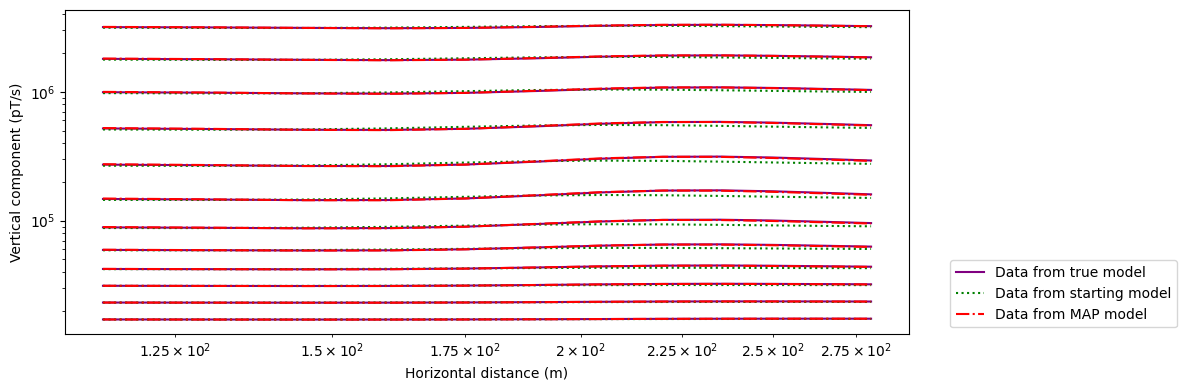

In [15]:

idx_to_plot = numpy.arange(8, 20)       # subset of numpy.arange(0, 44)

_, (ax1) = plt.subplots(1, 1, figsize=(12,4))
plot_predicted_profile(true_param_value, forward, "Data from true model", gate_idx=idx_to_plot, ax=ax1, cmp='vertical', color="purple")
plot_predicted_profile(init_param_value, forward, "Data from starting model", gate_idx=idx_to_plot, ax=ax1,cmp='vertical', color="green", linestyle=":")
plot_predicted_profile(my_result.model, forward, "Data from MAP model", gate_idx=idx_to_plot, ax=ax1, cmp='vertical',color="red", linestyle="-.")

ax1.legend(bbox_to_anchor=(1.04, 0), loc="lower left")
plt.tight_layout()

### Model

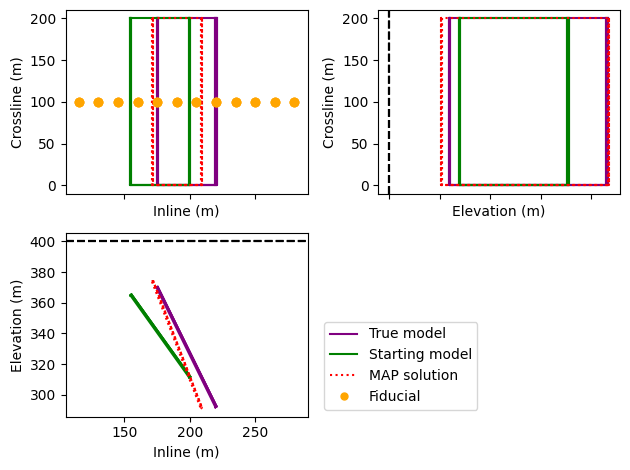

In [16]:
_, axes = plt.subplots(2, 2, sharex="col")
axes[1,1].axis("off")
plot_plate_faces(
    "plate_true", forward, true_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="purple", label="True model"
)
plot_plate_faces(
    "plate_init", forward, init_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="green", label="Starting model"
)
plot_plate_faces(
    "plate_inverted", forward, my_result.model, 
    axes[0,0], axes[0,1], axes[1,0], color="red", label="MAP solution", linestyle="dotted"
)

plt.tight_layout()

point = Line2D([0], [0], label='Fiducial', marker='o', markersize=5, 
         markeredgecolor='orange', markerfacecolor='orange', linestyle='')

handles, labels = axes[1,0].get_legend_handles_labels()
handles.extend([point])

axes[1,0].legend(handles=handles,bbox_to_anchor=(1.04, 0), loc="lower left")

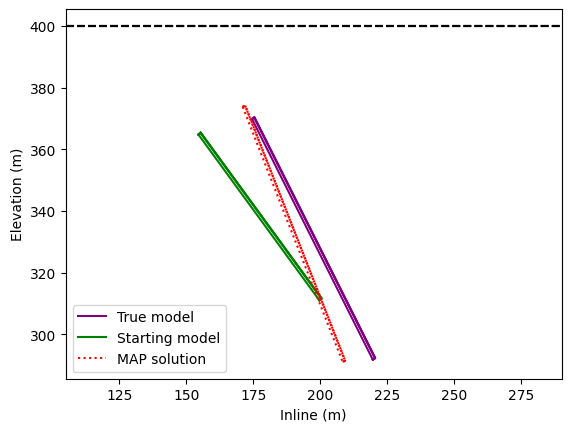

In [17]:
_, ax = plt.subplots(1, 1)
plot_plate_faces_single("plate_true", "xz", forward, true_param_value, ax, color="purple", label="True model")
plot_plate_faces_single("plate_init", "xz", forward, init_param_value, ax, color="green", label="Starting model")
plot_plate_faces_single("plate_inverted", "xz", forward, my_result.model, ax, color="red", label="MAP solution", linestyle="dotted")
ax.legend();

---
# Watermark

<!-- Feel free to add more modules in the watermark_list below, if more packages are used -->
<!-- Otherwise please leave the below code cell unchanged -->

In [18]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.9
numpy 2.0.1
scipy 1.14.0
matplotlib 3.9.1.post1
